In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, KFold, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime as dt
import scipy.stats as stats

from seaborn import regplot

## Loading and extracting input/output data

In [2]:
df = pd.read_csv('./wine+quality/winequality-red.csv', sep=";")
print(f'Shape of raw dataset: {df.shape}')
df.keys()

Shape of raw dataset: (1599, 12)


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [3]:
# Columns to ignore:
col_ignore = []

# Categorical columns to perform one-hot encoding:
col_ohe =[]

# Output column name:
output_col = ['quality']

# Drop unimportant columns (col_ignore):
df = df.drop(labels=col_ignore, axis=1)
print(f'Shape of input df after dropping unimportant cloumns: {df.shape}')

# One-Hot Encoding:
for ohe in col_ohe:
    df = pd.concat((df, pd.get_dummies(df[ohe])), axis=1)
    df = df.drop(labels=[ohe], axis=1)

print(f'Shape of input df after OHE: {df.shape}')

# Creating x,y data:
df_y = df[output_col]
df_x = df.drop(labels=output_col, axis=1)

input_dataset_x = df_x.to_numpy()
input_dataset_y = df_y.to_numpy()
print(f'Dataset shape:\nx: {input_dataset_x.shape},   y: {input_dataset_y.shape}', )

Shape of input df after dropping unimportant cloumns: (1599, 12)
Shape of input df after OHE: (1599, 12)
Dataset shape:
x: (1599, 11),   y: (1599, 1)


## Data preprocessing

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(input_dataset_x, input_dataset_y, test_size=0.25, random_state=13)
print(f'Size:  train set: {X_train.shape[0]}, test set: {X_test.shape[0]}')

# Standardizing the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(y_train)
y_test_s = scaler_y.transform(y_test)

Size:  train set: 1199, test set: 400


In [5]:
print(f'Target data range: min:\n{df_y.min()} \nmax:\n{df_y.max()}') 

Target data range: min:
quality    3
dtype: int64 
max:
quality    8
dtype: int64


## Feature correlation


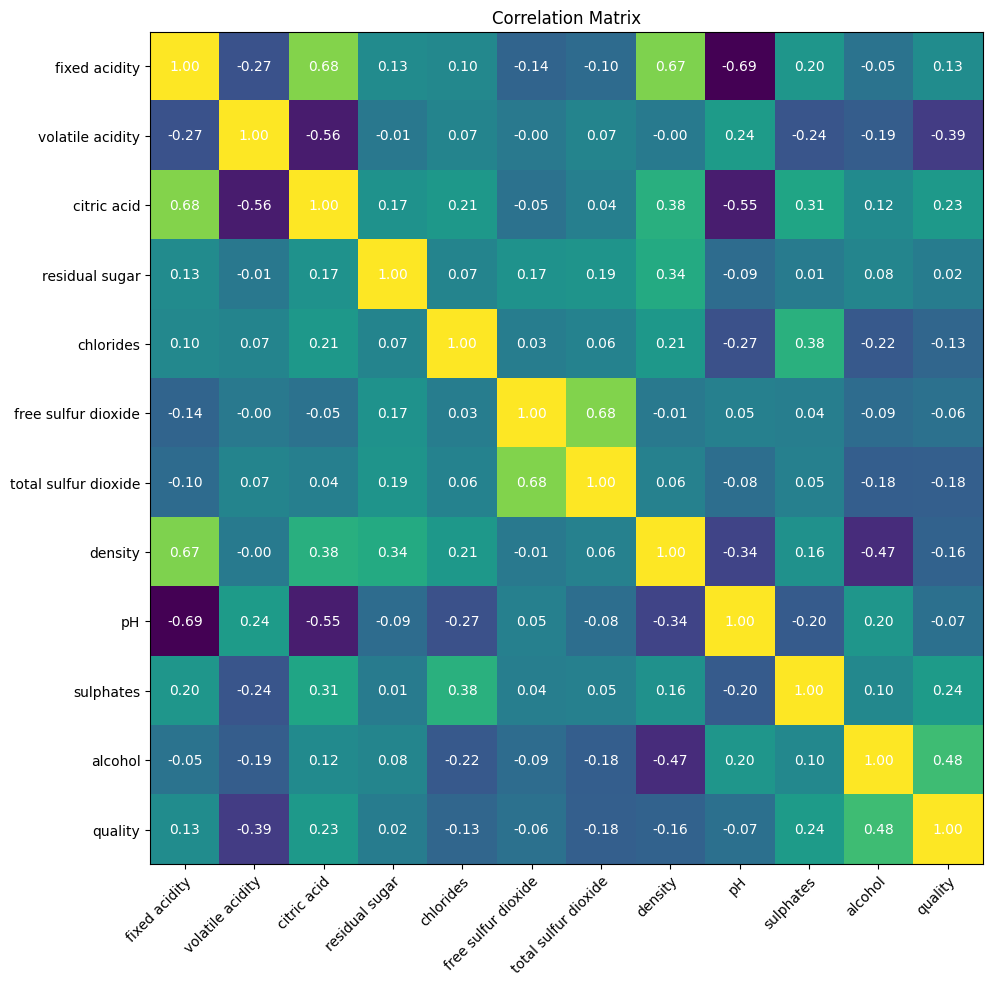

In [6]:
corr_mat = np.corrcoef(np.concatenate((X_train, y_train), axis=1), rowvar=False)

lbl_s = [x for x in df.keys()]

fig, ax = plt.subplots()
im = ax.imshow(corr_mat)

fig.set_size_inches(10, 10)

ax.set_xticks(np.arange(len(lbl_s)))
ax.set_yticks(np.arange(len(lbl_s)))

ax.set_xticklabels(lbl_s)
ax.set_yticklabels(lbl_s)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(lbl_s)):
    for j in range(len(lbl_s)):
        text = ax.text(j, i, f'{corr_mat[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title("Correlation Matrix")
fig.tight_layout()
plt.show()

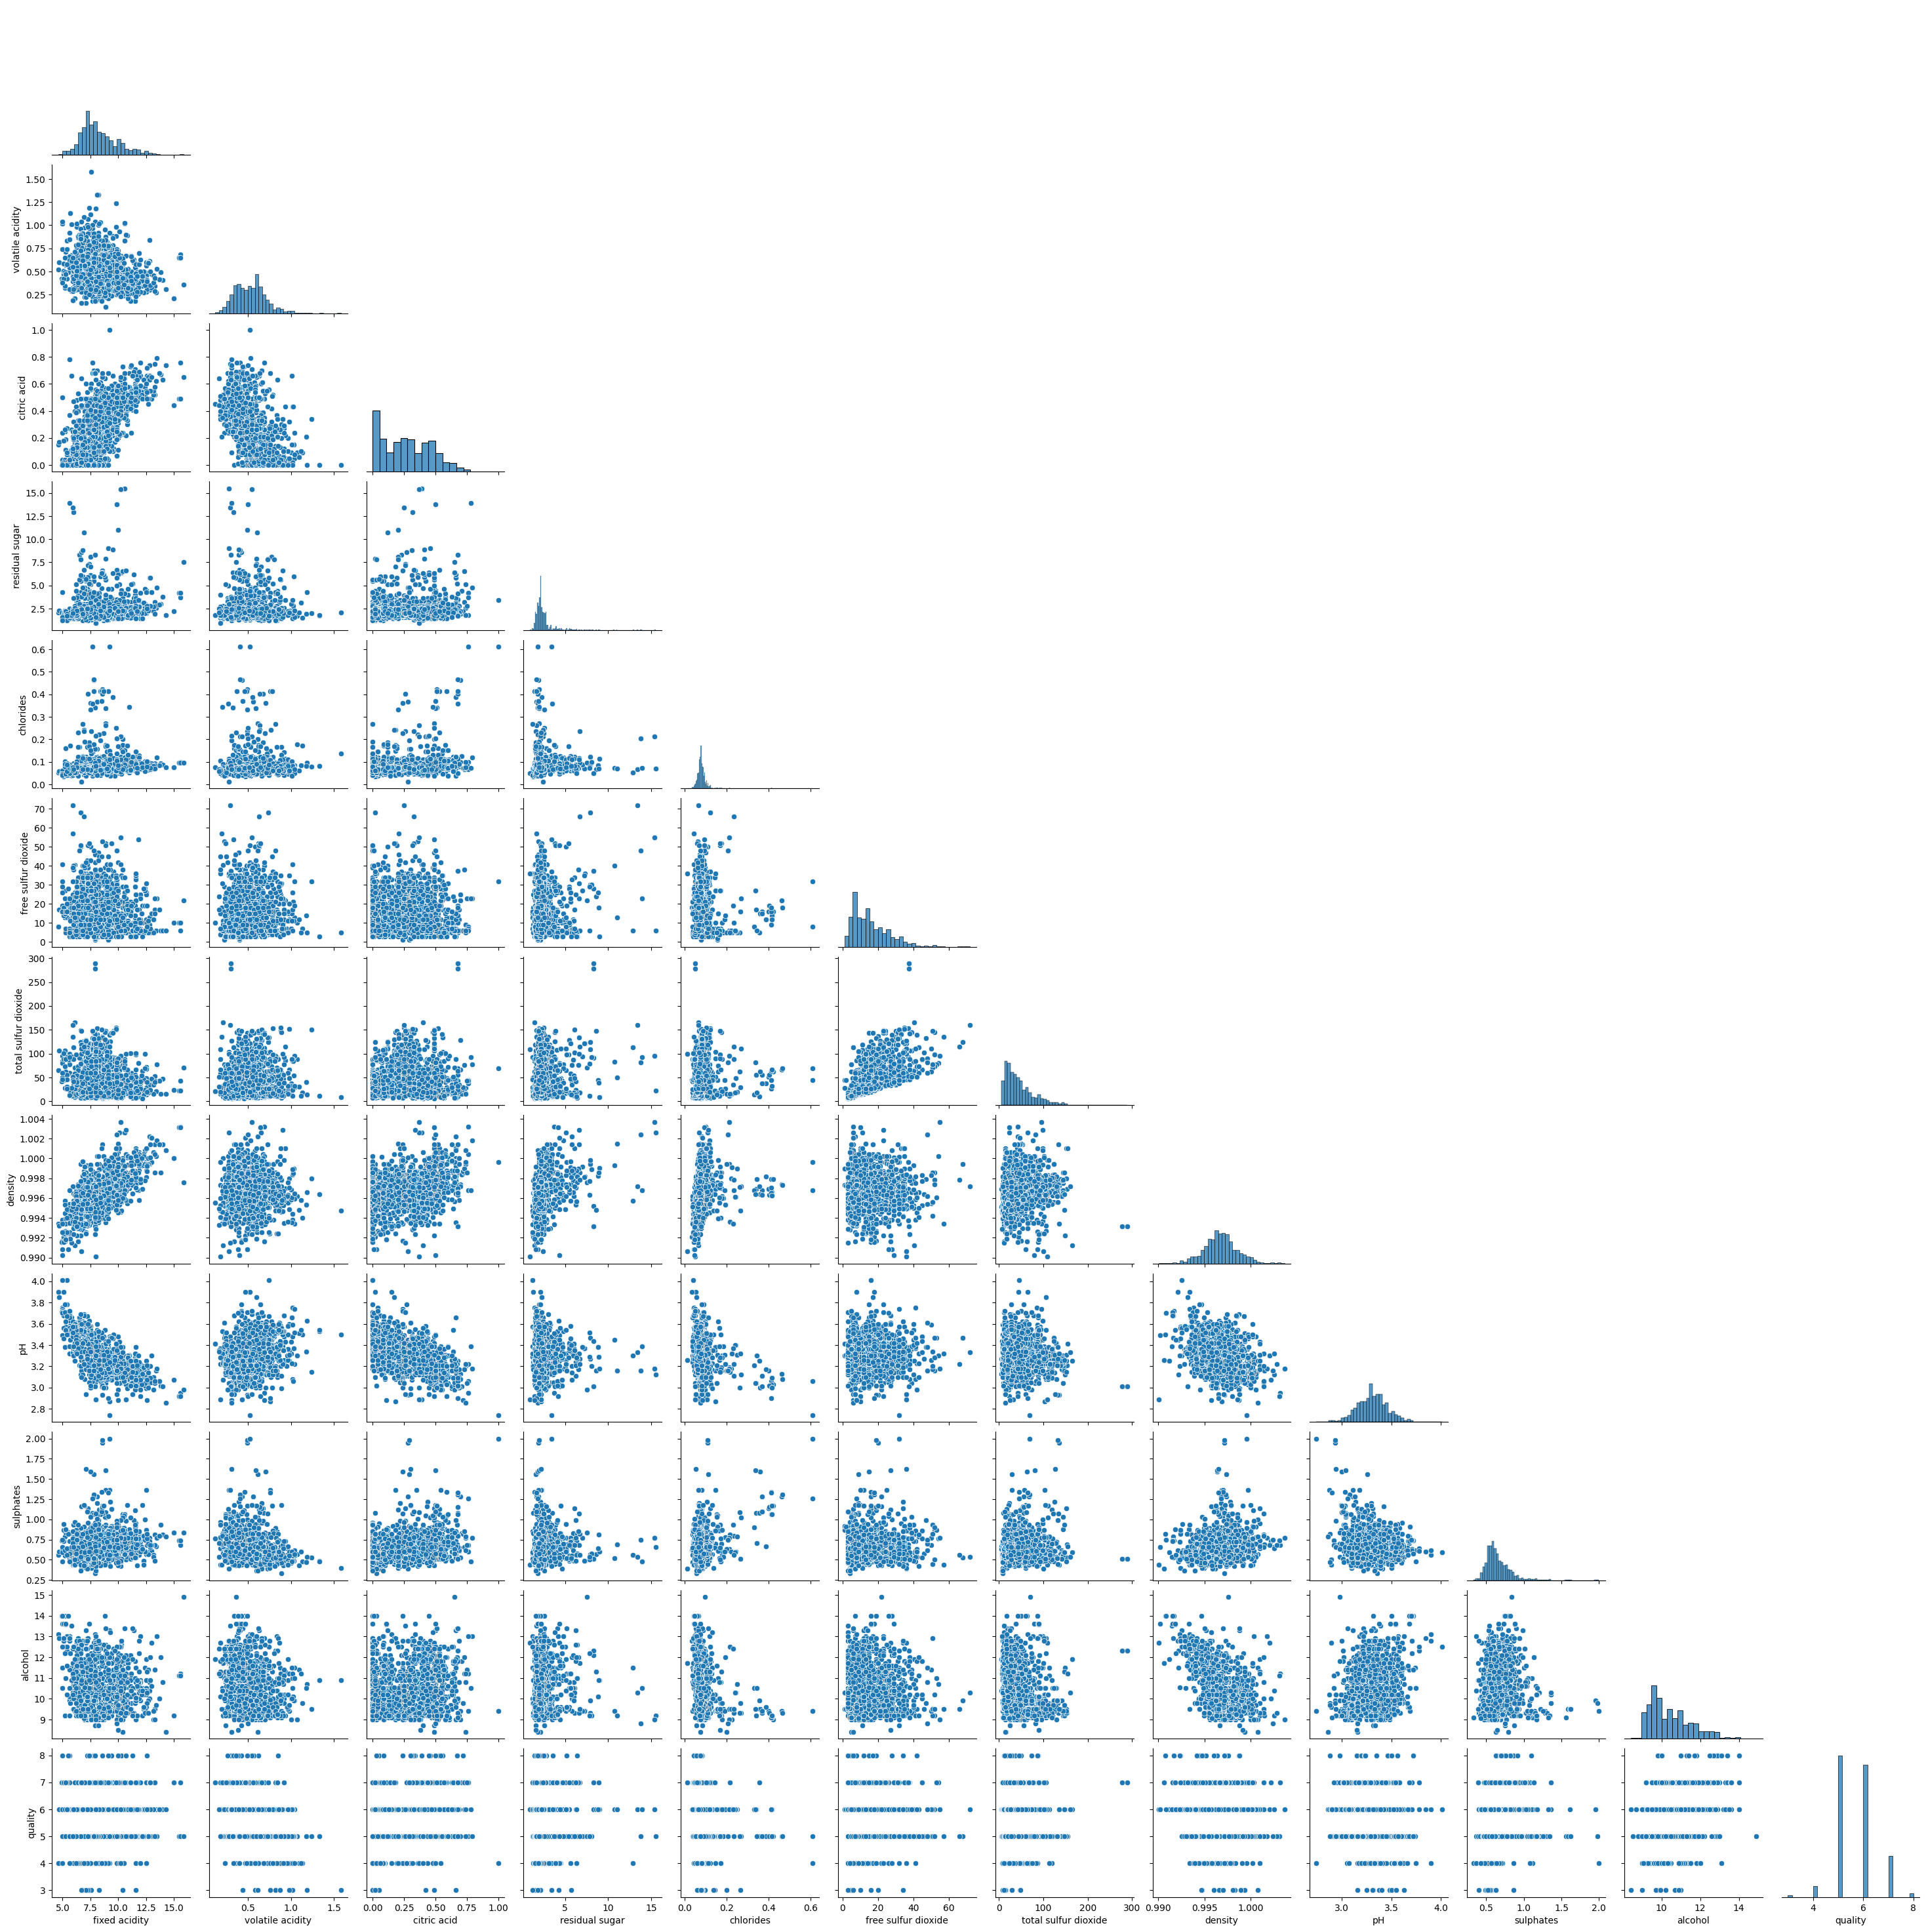

In [7]:
sns.pairplot(df, corner=True)

Text(0.5, 0, 'wine quality score')

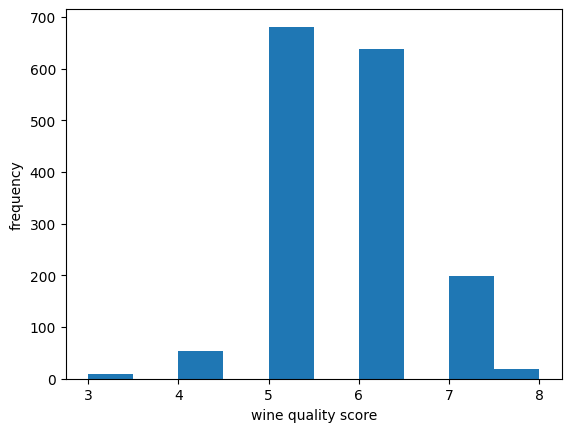

In [65]:
plt.hist(input_dataset_y)

plt.ylabel("frequency")
plt.xlabel("wine quality score")

## Cross validation report function:

In [39]:
def report_cv_scores(regressor, params, multioutput = 'raw_values'):
    
    train_rmse_run = []
    val_rmse_run = []
    test_rmse_run = []
    train_r2_run = []
    val_r2_run = []
    test_r2_run = []
    for i in range(1):
        model =  regressor.set_params(**params)
        
        train_rmse_cv = []
        val_rmse_cv = []
        train_r2_cv = []
        val_r2_cv = []
        kf = KFold(3, shuffle=True, random_state=9)
        for (train_ind, val_ind) in kf.split(X_train_s):
            X_train_cv_s = X_train_s[train_ind]
            y_train_cv_s = y_train_s[train_ind]
            X_val_cv_s = X_train_s[val_ind]
            y_val_cv_s = y_train_s[val_ind]

            model.fit(X_train_cv_s, y_train_cv_s)

            y_pred_train_s = model.predict(X_train_cv_s)
            y_pred_val_s = model.predict(X_val_cv_s)

            y_train_s_i = scaler_y.inverse_transform(y_train_cv_s)
            y_pred_train_s_i = scaler_y.inverse_transform(y_pred_train_s.reshape(-1, 1))

            y_val_s_i = scaler_y.inverse_transform(y_val_cv_s)
            y_pred_val_s_i = scaler_y.inverse_transform(y_pred_val_s.reshape(-1, 1))
            
            train_rmse_cv.append(mean_squared_error(y_train_s_i, y_pred_train_s_i, squared=False, multioutput=multioutput))
            val_rmse_cv.append(mean_squared_error(y_val_s_i, y_pred_val_s_i, squared=False, multioutput=multioutput))

            train_r2_cv.append(r2_score(y_train_s_i, y_pred_train_s_i, multioutput=multioutput))
            val_r2_cv.append(r2_score(y_val_s_i, y_pred_val_s_i, multioutput=multioutput))

        model =  regressor.set_params(**params)
        model.fit(X_train_s, y_train_s)
        y_pred_test_s = model.predict(X_test_s)
        y_test_s_i = scaler_y.inverse_transform(y_test_s)
        y_pred_test_s_i = scaler_y.inverse_transform(y_pred_test_s.reshape(-1, 1))
        test_rmse = mean_squared_error(y_test_s_i, y_pred_test_s_i, squared=False, multioutput=multioutput)
        test_r2 = r2_score(y_test_s_i, y_pred_test_s_i, multioutput=multioutput)
        
        train_rmse_run.append(np.mean(train_rmse_cv, axis=0))
        val_rmse_run.append(np.mean(val_rmse_cv, axis=0))
        test_rmse_run.append(test_rmse)
        
        train_r2_run.append(np.mean(train_r2_cv, axis=0))
        val_r2_run.append(np.mean(val_r2_cv, axis=0))
        test_r2_run.append(test_r2)
        
    print(f'RMSE      train= {np.mean(train_rmse_run, axis=0)}   val= {np.mean(val_rmse_run, axis=0)}  test= {np.mean(test_rmse_run, axis=0)}')
    print(f'R2 score  train= {np.mean(train_r2_cv, axis=0)}   val= {np.mean(val_r2_cv, axis=0)}  test= {np.mean(test_r2_run, axis=0)}')
    print(f'std(RMSE)      train= {np.std(train_rmse_run, axis=0)}   val= {np.std(val_rmse_run, axis=0)}  test= {np.std(test_rmse_run, axis=0)}')

## Hyperparamter Tuning:Random Search


In [40]:
regressors = [
                LinearRegression,
                DecisionTreeRegressor,
                RandomForestRegressor,
                MultiOutputRegressor(GradientBoostingRegressor(), n_jobs=4),
                MLPRegressor,
                GaussianProcessRegressor,
                KNeighborsRegressor
                ]

# a list of grid of arguments for the regressors    
param_grids = [
                {'fit_intercept': [True, False], 'positive': [False]},
    
                {'criterion': ['squared_error', 'poisson', 'friedman_mse'], 'min_samples_split': stats.randint(2, 150), 
                 'max_features': stats.randint(2, 8), 'min_samples_leaf': stats.randint(1, 10)},
                
                {'n_estimators': stats.randint(50, 200), 'max_features': stats.randint(2, 8), 'max_depth': stats.randint(2, 15),
                 'min_samples_split': stats.randint(2, 500), 'min_samples_leaf': stats.randint(1, 10)},
                
                {'estimator__n_estimators': stats.randint(50, 200), 'estimator__max_features': stats.randint(2, 8),
                 'estimator__max_depth': stats.randint(2, 15),'estimator__subsample': stats.uniform(0, 1),
                 'estimator__min_samples_split': stats.randint(2, 150), 'estimator__learning_rate': [0.1, 0.5]},
                
                {'hidden_layer_sizes':[(50,50), (100,100), (50,50,50), (100,100,100), (100,200,100), (200,200,200)],  
                 'learning_rate_init': stats.loguniform(1e-5, 5e-1), 'alpha': stats.loguniform(1e-5, 5e0-1), 
                 'momentum': stats.uniform(0, 1), 'activation':['relu','tanh','logistic'], 
                 'max_iter':[1000], 'solver': ['lbfgs', 'sgd', 'adam']},
              
                {'alpha': stats.loguniform(1e-8, 1e-1), 'n_restarts_optimizer': [0,1,2,4]},
                
                {'n_neighbors': stats.randint(2, 15), 'weights': ['uniform', 'distance'],
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': stats.randint(10, 50)}
                ]
models = []
for reg_num, (regressor, param_grid) in enumerate(zip(regressors, param_grids)):
    # Getting the name of regressor -- to be used for profiling.
    reg_cls = regressor.__class__
    if reg_cls == sklearn.multioutput.MultiOutputRegressor:
        name_reg = str(regressor.estimator)[:-2]
    else:
        name_reg = regressor.__name__
        regressor = regressor()
        
    print('\n', '>'*4, f'num= {reg_num} -Using regressor: ', name_reg)
    
    model = RandomizedSearchCV(regressor, param_grid,
                                n_iter=200,
                                n_jobs=-1,
                                cv=KFold(5, shuffle=True, random_state=9),
                                scoring='neg_root_mean_squared_error',
                                random_state=14).fit(X_train_s, y_train_s)
      
    models.append(model)
#     models[3] = model
    pd.DataFrame(model.cv_results_).to_excel(f'./results/RandomSearchCV_{str(dt.now()).replace(" ", "_").replace(":", "")}_{name_reg.replace(" ", "_")}.xlsx')

    print(f'Mean neg_RMSE score of best estimator {model.best_score_}')
    report_cv_scores(regressor, model.best_params_)


 >>>> num= 0 -Using regressor:  LinearRegression


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=200. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mean neg_RMSE score of best estimator -0.806665151774987
RMSE      train= [0.64407153]   val= [0.65137299]  test= [0.64793661]
R2 score  train= [0.36246388]   val= [0.34617993]  test= [0.35718597]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 1 -Using regressor:  DecisionTreeRegressor


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
330 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
330 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py", line 1320, in f

Mean neg_RMSE score of best estimator -0.8252950067351751
RMSE      train= [0.57160128]   val= [0.69675195]  test= [0.6832796]
R2 score  train= [0.49788333]   val= [0.2511694]  test= [0.2851462]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 2 -Using regressor:  RandomForestRegressor


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean neg_RMSE score of best estimator -0.7399289213900607


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 

RMSE      train= [0.39835849]   val= [0.60192724]  test= [0.58502831]
R2 score  train= [0.7562187]   val= [0.44220882]  test= [0.47594836]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 3 -Using regressor:  GradientBoostingRegressor
Mean neg_RMSE score of best estimator -0.7378004273191665
RMSE      train= [0.03390833]   val= [0.61807286]  test= [0.58017817]
R2 score  train= [0.99823088]   val= [0.41189668]  test= [0.48460158]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 4 -Using regressor:  MLPRegressor


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean neg_RMSE score of best estimator -0.7804724356410827


C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stoc

RMSE      train= [0.58961034]   val= [0.63832184]  test= [0.61996499]
R2 score  train= [0.46548558]   val= [0.37195758]  test= [0.41148891]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 5 -Using regressor:  GaussianProcessRegressor
Mean neg_RMSE score of best estimator -0.8174906798051023
RMSE      train= [0.14573109]   val= [0.66373115]  test= [0.61675807]
R2 score  train= [0.9672661]   val= [0.32144804]  test= [0.4175616]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]

 >>>> num= 6 -Using regressor:  KNeighborsRegressor
Mean neg_RMSE score of best estimator -0.7584439476249563
RMSE      train= [0.]   val= [0.61482583]  test= [0.57584137]
R2 score  train= [1.]   val= [0.41814381]  test= [0.49227793]
std(RMSE)      train= [0.]   val= [0.]  test= [0.]


In [61]:
y_test_pred_s_i_list = []
dataframe_np = [[], [], []]

model_names = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor',
               'GradientBoostingRegressor', 'MLPRegressor', 'GaussianProcessRegressor', 'KNeighborsRegressor']
plot_models = [6,1]
for i, model in enumerate(np.array(models)[plot_models]):
    
    y_pred_test_s = model.predict(X_test_s)
    y_test_s_i = scaler_y.inverse_transform(y_test_s)
    y_pred_test_s_i = scaler_y.inverse_transform(y_pred_test_s.reshape(-1, 1))
    temp = np.concatenate((y_pred_test_s_i, np.array([model_names[plot_models[i]] for _ in range(y_pred_test_s_i.shape[0])]).reshape(1, y_pred_test_s_i.shape[0]).T), axis=1)
    temp = np.concatenate((temp, y_test_s_i), axis=1)
    dataframe_np = np.concatenate((dataframe_np, temp.T), axis=1)
    
    y_test_pred_s_i_list.append(y_pred_test_s_i)
temp = np.concatenate((y_test_s_i, np.array(['Perfect Model' for _ in range(y_pred_test_s_i.shape[0])]).reshape(1, y_pred_test_s_i.shape[0]).T), axis=1)
temp = np.concatenate((temp, y_test_s_i), axis=1)
dataframe_np = np.concatenate((dataframe_np, temp.T), axis=1)
dataframe_np
columns =['Predicted wine quality', 'model', 'True wine quality']
data = pd.DataFrame(dataframe_np.T, columns=columns)
data['Predicted wine quality'] = data['Predicted wine quality'].apply(pd.to_numeric)
data['True wine quality'] = data['True wine quality'].apply(pd.to_numeric)


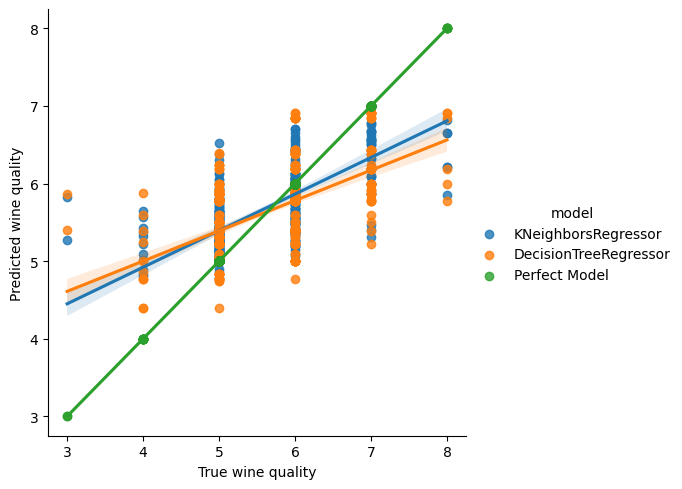

In [62]:
sns.lmplot(data=data, x='True wine quality', y='Predicted wine quality', hue='model', scatter=True)

In [58]:
model = models[1]
y_pred_train_s = model.predict(X_train_s)
y_pred_test_s = model.predict(X_test_s)

# Calculating the errors:
multioutput = 'raw_values'
# multioutput = 'uniform_average'
train_rmse = mean_squared_error(y_train_s, y_pred_train_s, squared=False, multioutput=multioutput)
test_rmse = mean_squared_error(y_test_s, y_pred_test_s, squared=False, multioutput=multioutput)
train_r2 = r2_score(y_train_s, y_pred_train_s, multioutput=multioutput)
test_r2 = r2_score(y_test_s, y_pred_test_s, multioutput=multioutput)
print(f'RMSE      train= {train_rmse}   test= {test_rmse} ')
print(f'R2 score  train= {train_r2}   test= {test_r2} ')

RMSE      train= [0.7041954]   test= [0.82217347] 
R2 score  train= [0.50410884]   test= [0.32589636] 


In [60]:
multioutput = 'raw_values'
# multioutput = 'uniform_average'

y_train_s_i = scaler_y.inverse_transform(y_train_s)
# y_pred_train_s_i = scaler_y.inverse_transform(y_pred_train_s)
y_pred_train_s_i = scaler_y.inverse_transform(y_pred_train_s.reshape(-1,1))
y_test_s_i = scaler_y.inverse_transform(y_test_s)
# y_pred_test_s_i = scaler_y.inverse_transform(y_pred_test_s)
y_pred_test_s_i = scaler_y.inverse_transform(y_pred_test_s.reshape(-1,1))
print("True labels (test set): \n", y_test_s_i[:5])
print("Predicted labels (test set): \n",y_pred_test_s_i[:5])

train_rmse = mean_squared_error(y_train_s_i, y_pred_train_s_i, squared=False, multioutput=multioutput)
test_rmse = mean_squared_error(y_test_s_i, y_pred_test_s_i, squared=False, multioutput=multioutput)
train_r2 = r2_score(y_train_s_i, y_pred_train_s_i, multioutput=multioutput)
test_r2 = r2_score(y_test_s_i, y_pred_test_s_i, multioutput=multioutput)
print(f'RMSE      train= {train_rmse}   test= {test_rmse} ')
print(f'R2 score  train= {train_r2}   test= {test_r2} ')

True labels (test set): 
 [[6.]
 [5.]
 [5.]
 [5.]
 [6.]]
Predicted labels (test set): 
 [[6.19354839]
 [5.3902439 ]
 [5.31111111]
 [6.19047619]
 [5.775     ]]
RMSE      train= [0.56830687]   test= [0.66351872] 
R2 score  train= [0.50410884]   test= [0.32589636] 
